# 2D UNETR for Kidney Segmentation(KiTS21)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# if repository is not downloaded (common if used colab link)
if not os.path.exists('./utils') and not os.path.exists('./models'):
    !git clone https://github.com/AAitorG/UNETR_2D.git UNETR_2D
    !python3 -m pip install -r UNETR_2D/requirements.txt

'UNETR_2D'에 복제합니다...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 29), reused 19 (delta 1), pack-reused 0 (from 0)
오브젝트를 받는 중: 100% (68/68), 1.37 MiB | 6.19 MiB/s, 완료.
델타를 알아내는 중: 100% (29/29), 완료.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 8.4 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... |

In [5]:
from UNETR_2D.utils import *
from UNETR_2D.models import *

import numpy as np
import cv2
import gc
from matplotlib import pyplot as plt
from skimage import metrics

import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.backend import clear_session

set_gpu(gpu_id=0)
set_seed()

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/platform/_pywrap_cpu_feature_guard.so, 0x0002): tried: '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/platform/_pywrap_cpu_feature_guard.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/platform/_pywrap_cpu_feature_guard.so' (no such file), '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/platform/_pywrap_cpu_feature_guard.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))

In [2]:
!mkdir KiTS21

mkdir: KiTS21: File exists


In [ ]:
!unzip /content/drive/MyDrive/KiTS21/train-kid-small.zip -d ./KiTS21/train

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./KiTS21/train/labels/090_028.png  
  inflating: ./KiTS21/train/labels/090_029.png  
  inflating: ./KiTS21/train/labels/090_030.png  
  inflating: ./KiTS21/train/labels/090_031.png  
  inflating: ./KiTS21/train/labels/090_032.png  
  inflating: ./KiTS21/train/labels/090_033.png  
  inflating: ./KiTS21/train/labels/090_034.png  
  inflating: ./KiTS21/train/labels/090_035.png  
  inflating: ./KiTS21/train/labels/090_036.png  
  inflating: ./KiTS21/train/labels/090_037.png  
  inflating: ./KiTS21/train/labels/090_038.png  
  inflating: ./KiTS21/train/labels/090_039.png  
  inflating: ./KiTS21/train/labels/090_040.png  
  inflating: ./KiTS21/train/labels/090_041.png  
  inflating: ./KiTS21/train/labels/090_042.png  
  inflating: ./KiTS21/train/labels/090_043.png  
  inflating: ./KiTS21/train/labels/090_044.png  
  inflating: ./KiTS21/train/labels/090_045.png  
  inflating: ./KiTS21/train/labels/090_046.png  
  inflating: ./KiTS21/train/label

In [ ]:
!unzip /content/drive/MyDrive/KiTS21/test-small.zip -d ./KiTS21/test

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./KiTS21/test/masks/259_025.png  
  inflating: ./KiTS21/test/masks/259_026.png  
  inflating: ./KiTS21/test/masks/259_027.png  
  inflating: ./KiTS21/test/masks/259_028.png  
  inflating: ./KiTS21/test/masks/259_029.png  
  inflating: ./KiTS21/test/masks/259_030.png  
  inflating: ./KiTS21/test/masks/259_031.png  
  inflating: ./KiTS21/test/masks/259_032.png  
  inflating: ./KiTS21/test/masks/259_033.png  
  inflating: ./KiTS21/test/masks/259_034.png  
  inflating: ./KiTS21/test/masks/259_035.png  
  inflating: ./KiTS21/test/masks/259_036.png  
  inflating: ./KiTS21/test/masks/259_037.png  
  inflating: ./KiTS21/test/masks/259_038.png  
 extracting: ./KiTS21/test/masks/259_039.png  
 extracting: ./KiTS21/test/masks/259_040.png  
 extracting: ./KiTS21/test/masks/259_041.png  
  inflating: ./KiTS21/test/masks/259_042.png  
  inflating: ./KiTS21/test/masks/259_043.png  
 extracting: ./KiTS21/test/masks/259_044.png  
 extracting: ./KiTS21/te

## Parameters

In [ ]:
data_path = './'
# Training dataset
train_datasets = 'KiTS21'
# Test dataset
test_datasets = 'KiTS21'

In [ ]:
## === Training parameters ===
# number of epochs
numEpochs = 300
# patience
patience = 30
# learning rate
lr = 1e-4
# weight_decay  (for AdamW)
wd = 1e-5
# Scheduler: 'oneCycle', 'reduce', 'cosine',  None
schedule = 'cosine'
# Optimizer name: 'Adam', 'SGD', 'rmsprop', 'AdamW'
optimizer_name = 'AdamW'
# Loss function name: 'bce', 'bce_dice', 'mse'
loss_acronym = 'focal_dice'
# batch size
batch_size_value = 8

In [ ]:
## === Network parameters ==
# Network architecture: UNETR_2D
model_name = 'UNETR_2D'
# initial filters (16 x num_channels)
num_filters = 32
# conv kernel initializer: 'glorot_uniform', 'he_normal'
kernel_init = 'he_normal'
# conv part activation function
activation = 'relu'
# patch size
patch_size = 8
# hidden dimension
hidden_dim = 64
# number of transformer encoders
transformer_layers = 4
# number of heads per MHA module
num_heads = 4
# transformer mlp dimentions
mlp_dim = [256, 64]
# number of output channels (number of classes)
out_channels = 1
# dropout value
dropout = 0.0
# multiple of ViT layers that will be used for each skip connection (Sm)
ViT_hidd_mult_skipC = 1
# Use Batch Normalization layers
batch_norm = True
# Use Data Augmentation
da = False
# tensorflow additional data augmentation layers
extra_tf_data_augmentation = None

In [ ]:
# === Extra parameters ===
# Load weights for FineTunning
use_saved_model = False
# Path to save weights (After training)
out_dir = '/content/drive/MyDrive/UNETR/FLDS/batch8lr1e-4/model_weights'
# Path to save plots
img_out_dir = '/content/drive/MyDrive/UNETR/FLDS/batch8lr1e-4/plots'
# filenames for trained model weights (h5)
weights_filename = out_dir + '/.weights.h5'
# Weights file path (weights that will be loaded if use_saved_model is TRUE)
model_path = ''

# image input size (this does not change the data size!)
input_shape = (256,256,1)
# number of random patches (with number lower than 0, sequential patches will be used)
n_patches = -1

# evaluation parameters
# patch size
patch_h, patch_w = (256,256)
# relevant patch size
relevant_h, relevant_w = (128,128)

## Prepare the data

In [ ]:
h_cuts = 0
v_cuts = 0

source_path = os.path.join(data_path, train_datasets, 'train')
ds_imgs, ds_lbls, ds_file_name, ds_label_file = get_xy_image_list(source_path)

assert len(ds_imgs) > 0, 'There in NO data, check path: {}.'.format(source_path)
assert len(ds_imgs) == len(ds_lbls), 'There is different ammount of images and labels. Images: {}  Labels: {}'.format(len(ds_imgs), len(ds_lbls))

h, w = ds_imgs[0].shape
exp_h, exp_w, _ = input_shape

h_cuts = int(np.ceil(w/exp_w))
v_cuts = int(np.ceil(h/exp_h))

#print("h_cuts: {} \t v_cuts: {}".format(h_cuts, v_cuts))

if w%exp_w != 0 and h%exp_h != 0:
    w_parts = w/exp_w
    h_parts = h/exp_h
    new_w = int(np.ceil(w_parts))*exp_w
    new_h = int(np.ceil(h_parts))*exp_h
    # MIRROR PADDING
    ds_imgs = [mirror_border(x, new_h, new_w) for x in ds_imgs]
    ds_lbls = [mirror_border(x, new_h, new_w) for x in ds_lbls]
    # ZERO PADDING (for 256x256 patches by default)
    #ds_imgs = [add_padding(x) for x in ds_imgs]
    #ds_lbls = [add_padding(x) for x in ds_lbls]

if n_patches < 0:
    # sequential patches
    ds_imgs = create_patches( ds_imgs, h_cuts, v_cuts )
    ds_lbls = create_patches( ds_lbls, h_cuts, v_cuts )

    #ds_imgs, ds_lbls = filter_patches(ds_imgs, ds_lbls)
else:
    # random patches
    p_ds_imgs = []
    p_ds_lbls = []
    while len(p_ds_imgs)<n_patches:
        a,b = create_random_patches( ds_imgs, ds_lbls, 1, [256, 256] )
        #a, b = filter_patches(a, b)
        p_ds_imgs = p_ds_imgs + a
        p_ds_lbls = p_ds_lbls + b
    ds_imgs = p_ds_imgs[:n_patches]
    ds_lbls = p_ds_lbls[:n_patches]

ds_imgs = np.expand_dims(ds_imgs, axis=-1)
ds_lbls = np.expand_dims(ds_lbls, axis=-1)

input_images = np.array(ds_imgs)
gt_labels = np.array(ds_lbls)

train_data_size = input_images.shape[0] * 0.9
val_data_size = input_images.shape[0] * 0.1

print('\n Data shape:',input_images.shape)

Input images loaded: 8837 -- Label images loaded: 8837
	path: ./KiTS21/train

 Data shape: (8837, 256, 256, 1)


In [ ]:
# Get generator
train_generator, val_generator = get_train_val_generators(  X_data = input_images,
                                                            Y_data = input_images if loss_acronym == 'mse' else gt_labels,
                                                            validation_split = 0.2,
                                                            rescale = 1./255,
                                                            horizontal_flip=True if da else False,
                                                            vertical_flip=True if da else False,
                                                            rotation_range = 180 if da else 0,
                                                            #width_shift_range=0.2,
                                                            #height_shift_range=0.2,
                                                            #shear_range=0.2,
                                                            batch_size=batch_size_value,
                                                            show_examples=False,
                                                            preprocessing_function = crappify if loss_acronym == 'mse' else None,
                                                            val_preprocessing_function = crappify if loss_acronym == 'mse' else None, )

Train batch shapes: x=(8, 256, 256, 1), y=(8, 256, 256, 1)
Validation batch shapes: x=(8, 256, 256, 1), y=(8, 256, 256, 1)


## Compile


In [ ]:
# Free up RAM in case the model definition cells were run multiple times
clear_session()
gc.collect()

model = UNETR_2D(
        input_shape = input_shape,
        patch_size = patch_size,
        num_patches = (input_shape[0]**2)//(patch_size**2),
        projection_dim = hidden_dim,
        transformer_layers = transformer_layers,
        num_heads = num_heads,
        transformer_units = mlp_dim,
        data_augmentation = extra_tf_data_augmentation,
        num_filters = num_filters,
        num_classes = out_channels,
        decoder_activation = activation,
        decoder_kernel_init = kernel_init,
        ViT_hidd_mult=ViT_hidd_mult_skipC,
        batch_norm = batch_norm,
        dropout = dropout,)


model.summary()

# Cosine Scheduler 설정
steps = int(np.ceil(train_data_size / batch_size_value) * numEpochs)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,  # 초기 학습률 값 설정
    decay_steps=steps
)

# Optimizer 설정
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches (Patches)         │ (None, None, 64)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 1024, 64)       │         69,696 │ patches[0][0]          │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1024, 64)       │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1024, 64)       │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1024, 64)       │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 1024, 64)       │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024, 256)      │         16,640 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024, 256)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024, 64)       │         16,448 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024, 64)       │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1024, 64)       │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1024, 64)       │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1024, 64)       │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1024, 64)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├──────────────────────

 Total params: 1,423,457 (5.43 MB)

 Trainable params: 1,421,921 (5.42 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
def target_dsc(y_true, y_pred, target_class=1):
    # 특정 클래스 마스크 생성
    y_true = tf.cast(tf.equal(y_true, tf.constant(target_class, dtype=y_true.dtype)), tf.float32)
    y_pred = tf.cast(tf.equal(tf.cast(y_pred > 0.5, tf.int32), tf.constant(target_class, dtype=tf.int32)), tf.float32)

    # 교집합 및 합집합 계산
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  # 배치별 교집합
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])  # 배치별 합집합

    # Dice Coefficient 계산
    dsc = tf.where(
        tf.equal(union, 0),
        tf.ones_like(intersection),  # 합집합이 0인 경우 Dice=1
        (2.0 * intersection) / union
    )

    # 배치 평균 반환
    return tf.reduce_mean(dsc)


In [ ]:
class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name="dice", **kwargs):
        super(DiceCoefficient, self).__init__(name=name, **kwargs)
        self.dice = self.add_weight(name="dice", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # 이진화 작업: 0.5를 기준으로 y_pred를 이진화
        y_pred = tf.cast(y_pred > 0.5, tf.float32)  # 확률 값 -> 이진 값
        y_true = tf.cast(y_true, tf.float32)        # y_true를 float32로 변환

        # 교집합 및 합집합 계산
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])

        # Dice Coefficient 계산
        dice = tf.where(
            tf.equal(union, 0),
            tf.ones_like(intersection),  # union이 0인 경우 Dice=1
            (2.0 * intersection) / union
        )

        # 배치 평균을 state에 저장
        self.dice.assign(tf.reduce_mean(dice))

    def result(self):
        return self.dice

    def reset_states(self):
        self.dice.assign(0.0)


In [ ]:
if loss_acronym == 'bce':
    loss_funct = 'binary_crossentropy'
elif loss_acronym == 'bce_dice':
    loss_funct = bce_dice_loss
elif loss_acronym == 'mse': # dont change this acronym (is used to know when is training for denoising)
    loss_funct = 'mean_squared_error'
elif loss_acronym == 'focal_dice':
    loss_funct = focal_dice_loss(alpha=0.9, gamma=2.0)



# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optimizer, loss=loss_funct, metrics=[target_dsc, 'accuracy', DiceCoefficient()])

In [ ]:
# EarlyStopping 설정
callbacks = [
    EarlyStopping(patience=patience, monitor='val_target_dsc', mode='max', verbose=1, restore_best_weights=True)
]

# 모델 훈련
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=int(np.ceil(train_data_size / batch_size_value)),
    validation_steps=int(np.ceil(val_data_size / batch_size_value)),
    epochs=numEpochs,
    callbacks=callbacks
)


Epoch 1/300
995/995 ━━━━━━━━━━━━━━━━━━━━ 291s 233ms/step - accuracy: 0.9514 - dice: 0.6847 - loss: 0.4797 - target_dsc: 0.5479 - val_accuracy: 0.9904 - val_dice: 0.2612 - val_loss: 0.3964 - val_target_dsc: 0.5995
Epoch 2/300
995/995 ━━━━━━━━━━━━━━━━━━━━ 199s 200ms/step - accuracy: 0.9939 - dice: 0.8249 - loss: 0.1447 - target_dsc: 0.7981 - val_accuracy: 0.9949 - val_dice: 0.9909 - val_loss: 0.1799 - val_target_dsc: 0.7997
Epoch 3/300
995/995 ━━━━━━━━━━━━━━━━━━━━ 200s 201ms/step - accuracy: 0.9953 - dice: 0.8519 - loss: 0.1044 - target_dsc: 0.8396 - val_accuracy: 0.9922 - val_dice: 0.1872 - val_loss: 0.2279 - val_target_dsc: 0.7619
Epoch 4/300
995/995 ━━━━━━━━━━━━━━━━━━━━ 200s 201ms/step - accuracy: 0.9957 - dice: 0.8666 - loss: 0.0939 - target_dsc: 0.8486 - val_accuracy: 0.9941 - val_dice: 0.4145 - val_loss: 0.2148 - val_target_dsc: 0.7702
Epoch 5/300
995/995 ━━━━━━━━━━━━━━━━━━━━ 200s 201ms/step - accuracy: 0.9963 - dice: 0.8837 - loss: 0.0753 - target_dsc: 0.8746 - val_accuracy: 0.994

### Save weights

In [ ]:
# Save weights for future reuse
create_dir(out_dir)
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

Saved model as /content/drive/MyDrive/UNETR/FLDS/batch8lr1e-4/model_weights/.weights.h5


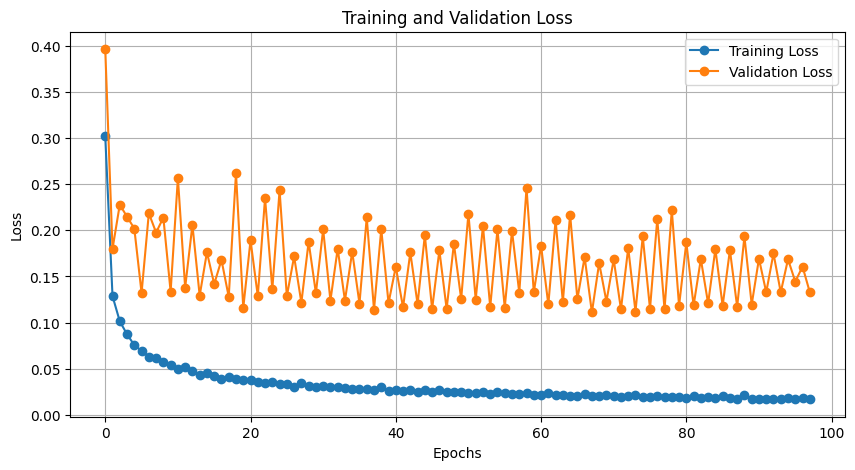

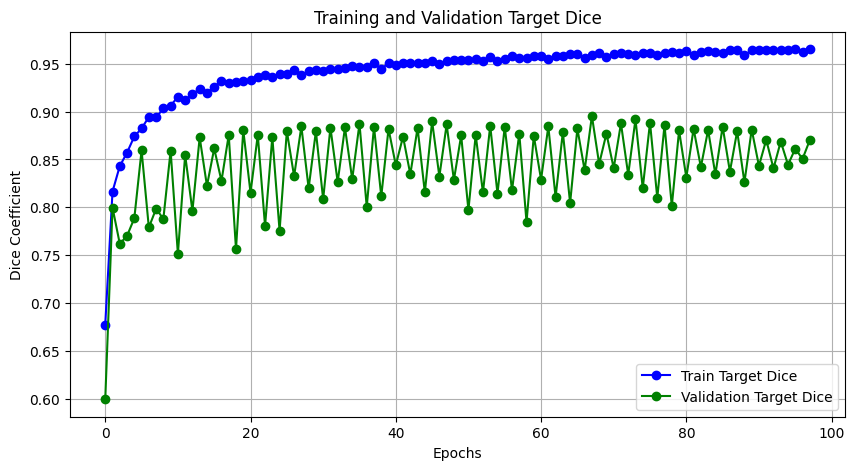

In [ ]:
import matplotlib.pyplot as plt

# Plot 1: Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Target DSC vs Dice Coefficient
plt.figure(figsize=(10, 5))
plt.plot(history.history['target_dsc'], label='Train Target Dice', marker='o', color='blue')
plt.plot(history.history['val_target_dsc'], label='Validation Target Dice', marker='o', color='green')
plt.title('Training and Validation Target Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation with Test Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트 경로
checkpoint_path = '/content/drive/MyDrive/UNETR/FLDS/batch8lr1e-4/model_weights/.weights.h5'


# 모델 구조 불러오기 및 가중치 복원
model.load_weights(checkpoint_path)

In [ ]:
### FULL IMAGE using relevant patch + sliding window + mirror padding
print('TEST: ', test_datasets)
source_test_data_path = os.path.join(data_path, test_datasets, 'test')
test_img, test_lbl, test_img_paths, test_lbl_paths = get_xy_image_list(source_test_data_path)

# Prepare the test data
X_test = [x/255 for x in test_img] # normalize between 0 and 1
X_test = np.expand_dims( np.asarray(X_test, dtype=np.float32), axis=-1 ) # add extra dimension
Y_test = [x/255 for x in test_lbl] # normalize between 0 and 1
Y_test = np.expand_dims( np.asarray(Y_test, dtype=np.float32), axis=-1 ) # add extra dimension

b, h, w, c = X_test.shape
print("\nTest shape =", X_test.shape )


TEST:  KiTS21
Input images loaded: 12233 -- Label images loaded: 12233
	path: ./KiTS21/test

Test shape = (12233, 256, 256, 1)


Inferring and measuring

In [ ]:
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm

# 결과 저장 디렉토리 설정
result_save_dir = '/content/drive/MyDrive/UNETR/FLDS/batch8lr1e-4/format_results/'
os.makedirs(result_save_dir, exist_ok=True)  # 디렉토리 생성

# Dice coefficient 계산 함수 정의
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# IoU, mDice, target Dice 저장 리스트
test_iou = []
test_mdice = []
test_target_dice = []
test_psnr = []
test_ssim = []
test_mse = []
preds_test = []
input_test = []
i = 0

for idx, img in tqdm(enumerate(test_img)):
    # 원본 파일 이름 가져오기
    original_filename = os.path.basename(test_img_paths[idx])  # 파일 경로에서 이름 추출
    file_name_without_ext = os.path.splitext(original_filename)[0]  # 확장자 제거

    # 이미지를 모델 입력 형식으로 변환
    img_norm = img / 255.0  # normalize between 0 and 1
    img_expanded = np.expand_dims(img_norm, axis=-1)  # add extra dimension
    h, w, _ = img_expanded.shape

    # Padding 설정
    if w % relevant_w != 0 and h % relevant_h != 0:
        w_parts = w / relevant_w
        h_parts = h / relevant_h
        new_w = int(np.ceil(w_parts)) * relevant_w
        new_h = int(np.ceil(h_parts)) * relevant_h
        pad_h = new_h - h  # if pad==11 (odd): 6 top (near 0) - 5 bot
        pad_w = new_w - w  # if pad==11 (odd): 6 L   (near 0) - 5 R
        same_shape_windows = False
    else:
        new_h = h + relevant_h
        new_w = w + relevant_w
        pad_h = relevant_h
        pad_w = relevant_w
        same_shape_windows = True

    # 패딩 적용
    image = np.expand_dims(mirror_border(img_expanded[:, :, 0], new_h, new_w), axis=-1)

    rows = []
    x_rows = []

    # create patches of (patch_h, patch_w) with (relevant_h, relevant_w) overlap between them
    for j in range(0, image.shape[0] - relevant_h, relevant_h):

        is_first_column = j == 0
        is_last_column = j == (image.shape[0] - relevant_h * 2)

        columns = []  # patches of the first row
        for k in range(0, image.shape[1] - relevant_w, relevant_w):
            window = image[j:j + patch_h, k:k + patch_w, :]
            columns.append(window)
        columns = np.array(columns)

        # prepare ground truth (y)
        y = Y_test[idx, :, :, 0]  # Ground truth
        _preds_test = model.predict_on_batch(columns)

        relevant_windows = _preds_test[:, relevant_h // 2:patch_h - (relevant_h // 2),
                                       relevant_w // 2:patch_w - (relevant_w // 2), :]

        x_relevant = columns[:, relevant_h // 2:patch_h - (relevant_h // 2),
                             relevant_w // 2:patch_w - (relevant_w // 2), :]

        rows.append(cv2.hconcat(relevant_windows))  # append relevant complete row
        x_rows.append(cv2.hconcat(x_relevant))

    x_recons = cv2.vconcat(x_rows)
    input_test.append(x_recons)
    recons_parts = cv2.vconcat(rows)
    preds_test.append(recons_parts)  # append complete image

    # Calculate metrics
    if loss_acronym == 'mse':
        test_psnr.append(metrics.peak_signal_noise_ratio(recons_parts, y))
        test_ssim.append(metrics.structural_similarity(recons_parts, y))
        test_mse.append(metrics.mean_squared_error(recons_parts, y))
    else:
        # IoU
        iou = jaccard_index(y, recons_parts >= 0.5)
        test_iou.append(iou)

        # Ground truth와 Prediction 준비
        binary_prediction = (recons_parts >= 0.5).astype(np.float32)  # Binarize predictions

        # 결과 이미지 저장 (원본 이름 기반)
        save_path = os.path.join(result_save_dir, f"{file_name_without_ext}_result.png")
        result_image = (binary_prediction * 255).astype(np.uint8)  # 0~255로 스케일링
        cv2.imwrite(save_path, result_image)

        # Dice metrics
        target_dice = dice_coefficient((y == 1).astype(np.float32), binary_prediction)
        test_target_dice.append(target_dice)
        mdice = dice_coefficient(y, binary_prediction)
        test_mdice.append(mdice)

        print(f"Slide {file_name_without_ext}: IoU = {iou:.4f}, Target Dice = {target_dice:.4f}, mDice = {mdice:.4f}")



